In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def binary_sequence_tensor(num_bits, length):
    # Create a tensor of shape (length,) with values from 0 to length - 1
    t_values = torch.arange(1,length+1) #start with 1

    # Create a tensor to store the binary representations
    binary_tensor = ((t_values.unsqueeze(1) >> torch.arange(num_bits)) & 1).float()
    binary_tensor[binary_tensor == 0] = 0
    return binary_tensor








In [4]:
num_bits = 20
length = 100000

res = binary_sequence_tensor(num_bits, length)
res

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [9]:
res.mean(dim=-1)

tensor([0.0500, 0.0500, 0.1000,  ..., 0.4500, 0.5000, 0.3000])

In [3]:


def plot_histogram(tensor, num_bins):
    # Convert tensor to numpy array for plotting
    data = tensor.numpy()

    # Create the histogram
    plt.hist(data, bins=num_bins, edgecolor='black', alpha=0.7)

    # Add labels and title
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title(f'Histogram with {num_bins} Bins')

    # Show the plot
    plt.show()



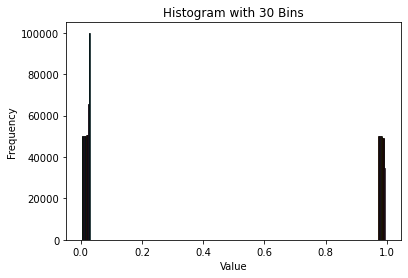

In [12]:


num_bins = 30  # Specify the number of bins
plot_histogram(res, num_bins)

In [4]:


def count_duplicates(tensor):
    # Check the shape of the tensor
    if tensor.dim() != 2:
        raise ValueError("Input tensor must be 2-dimensional (length x bits).")

    # Convert the tensor to a set of tuples to find unique rows
    unique_rows = set(map(tuple, tensor.tolist()))
    
    # Calculate the number of duplicates
    num_duplicates = tensor.size(0) - len(unique_rows)
    
    return num_duplicates




In [24]:
duplicates_count = count_duplicates(res)
print(f"Number of duplicate rows: {duplicates_count}")

Number of duplicate rows: 0


In [5]:


def calculate_changes_distribution(tensor):
    # Check the shape of the tensor
    if tensor.dim() != 2:
        raise ValueError("Input tensor must be 2-dimensional (length x bits).")

    # Calculate the number of changes between consecutive rows
    changes = torch.sum(tensor[1:] != tensor[:-1], dim=1)  # Compare consecutive rows

    # Create a histogram of the changes
    change_distribution = torch.bincount(changes)

    return change_distribution

def plot_changes_distribution(distribution):
    # Plot the distribution of changes
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(distribution)), distribution.numpy())
    plt.xlabel('Number of Changes')
    plt.ylabel('Frequency')
    plt.title('Distribution of Changes Between Consecutive Rows')
    plt.xticks(range(len(distribution)))
    plt.grid(axis='y')
    plt.show()


changes_distribution = calculate_changes_distribution(res)
plot_changes_distribution(changes_distribution)


NameError: name 'res' is not defined

In [6]:


def find_max_changes_indices(binary_tensor, index):
    # Check the shape of the tensor
    if binary_tensor.dim() != 2:
        raise ValueError("Input tensor must be 2-dimensional (length x bits).")

    if index < 0 or index >= binary_tensor.size(0):
        raise ValueError("Index must be within the range of the first dimension of the tensor.")

    # Calculate changes with respect to the specified index
    target_row = binary_tensor[index]
    changes = torch.sum(binary_tensor != target_row, dim=1)  # Count changes for each row compared to the target row

    # Find the indices with the maximum number of changes
    max_changes = changes.max().item()
    max_change_indices = torch.nonzero(changes == max_changes).squeeze().tolist()

    return max_change_indices

# Example usage

index = 1000  # Row to compare against
max_changes_indices = find_max_changes_indices(res, index)
print(f"Indices with the most changes compared to row {index}: {max_changes_indices}")


NameError: name 'res' is not defined

In [7]:
import torch

def shuffle_tensor(tensor):
    # Check if the input tensor is 2-dimensional
    if tensor.dim() != 2:
        raise ValueError("Input tensor must be 2-dimensional (length x bits).")

    length = tensor.size(0)
    shuffled_tensor = torch.zeros_like(tensor)

    # Rearranging indices: first last, second second to last, etc.
    for i in range(length):
        if i % 2 == 0:  # Even indices: take from the front
            shuffled_tensor[i] = tensor[i // 2]
        else:  # Odd indices: take from the back
            shuffled_tensor[i] = tensor[length - (i // 2) - 1]

    return shuffled_tensor

# Example usage
input_tensor = torch.tensor([[1], [2], [3], [4], [5]])
print("Input Tensor:")
print(input_tensor)

shuffled_tensor = shuffle_tensor(input_tensor)
print("Shuffled Tensor:")
print(shuffled_tensor)


Input Tensor:
tensor([[1],
        [2],
        [3],
        [4],
        [5]])
Shuffled Tensor:
tensor([[1],
        [5],
        [2],
        [4],
        [3]])


In [189]:
res_shuf = shuffle_tensor(res[:97301])

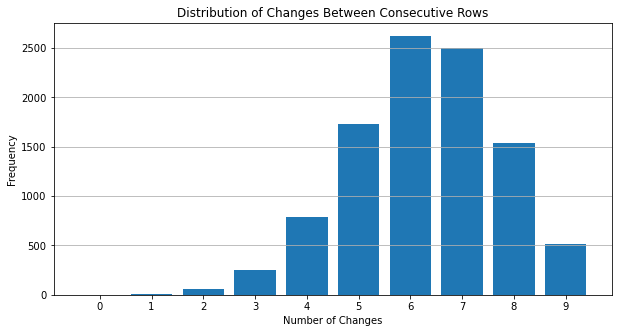

In [190]:
changes_distribution_s = calculate_changes_distribution(res_shuf)
plot_changes_distribution(changes_distribution_s)

In [87]:

from scipy.special import legendre

def generate_legendre_tensor(length, hidden_dim):
    # Generate a tensor to hold the Legendre polynomial values
    tensor = torch.zeros((length, hidden_dim))

    # Generate Legendre polynomials and populate the tensor
    for n in range(hidden_dim):
        # Create an array of x values between -1 and 1
        x_values = np.linspace(-1, 1, length)
        # Calculate the Legendre polynomial for degree n
        P_n = legendre(n)(x_values)

        # Normalize to [0, 1]
        P_n_min = P_n.min()
        P_n_max = P_n.max()
        if P_n_max > P_n_min:  # Avoid division by zero
            normalized_P_n = (P_n - P_n_min) / (P_n_max - P_n_min)
        else:
            normalized_P_n = np.zeros_like(P_n)  # All values are the same

        # Convert to PyTorch tensor and assign
        tensor[:, n] = torch.tensor(normalized_P_n, dtype=torch.float32)

    # Set one entry to 1 (intercept) and adjust others to be close to 0.5
    intercept_index = np.random.randint(hidden_dim)
    tensor[:, intercept_index] = 1.0  # Set intercept to 1

    # Normalize again to ensure all values stay between 0 and 1
    tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min() + 1e-8)  # Adding a small value to avoid division by zero

    return tensor

# Example usage:
length = 100000  # Desired length
hidden_dim = 200  # Desired hidden dimension
generated_tensor = generate_legendre_tensor(length, hidden_dim)

print("Average along length:\n", generated_tensor.mean(dim=0))


/Users/dallin.gordon/opt/anaconda3/lib/python3.9/site-packages/scipy/special/orthogonal.py:139: RuntimeWarning: invalid value encountered in multiply
  np.poly1d.__init__(self, poly.coeffs * float(kn))
/Users/dallin.gordon/opt/anaconda3/lib/python3.9/site-packages/scipy/special/orthogonal.py:2131: RuntimeWarning: overflow encountered in double_scalars
  kn = _gam(2 * n + 1) / _gam(n + 1)**2 / 2.0**n
/Users/dallin.gordon/opt/anaconda3/lib/python3.9/site-packages/scipy/special/orthogonal.py:2131: RuntimeWarning: invalid value encountered in double_scalars
  kn = _gam(2 * n + 1) / _gam(n + 1)**2 / 2.0**n


Average along length:
 tensor([0.0000, 0.5000, 0.3333, 0.5000, 0.3000, 0.5000, 0.2932, 0.5000, 0.2906,
        0.5000, 0.2894, 0.5000, 0.2887, 0.5000, 0.2883, 0.5000, 0.2880, 0.5000,
        0.2879, 0.5000, 0.2877, 0.5000, 0.2876, 0.5000, 0.2875, 0.5000, 0.2875,
        0.5000, 0.2874, 0.5000, 0.2874, 0.5000, 0.2874, 0.5000, 0.2873, 0.5000,
        0.2873, 0.5000, 0.2873, 0.5000, 0.2873, 0.5000, 0.2873, 0.5000, 0.2873,
        0.5000, 0.2872, 0.5000, 0.2872, 0.5000, 0.2872, 0.5000, 0.2872, 0.5000,
        0.2872, 0.5000, 0.2872, 0.5000, 0.2872, 0.5000, 0.2872, 0.5000, 0.2872,
        0.5000, 0.2872, 0.5000, 0.2872, 0.5000, 0.2872, 0.5000, 0.2872, 0.5000,
        0.2872, 0.5000, 0.2872, 0.5000, 0.2872, 0.5000, 0.2871, 0.5000, 0.2871,
        0.5000, 0.2872, 0.5000, 0.2871, 0.5000, 0.2872, 0.5000, 0.2872, 0.5000,
        0.2872, 0.5000, 0.2872, 0.5000, 0.2872, 0.5000, 0.2871, 0.5000, 1.0000,
        0.5000, 0.2871, 0.5000, 0.2871, 0.5000, 0.2871, 0.5000, 0.2871, 0.5000,
        0.2871, 0

In [60]:
outer_product = generated_tensor.unsqueeze(2) * generated_tensor.unsqueeze(1)
outer_product.shape
flattened_tensor = outer_product.reshape(outer_product.shape[0], -1)
flattened_tensor.shape

torch.Size([100000, 400])

torch.Size([100000])


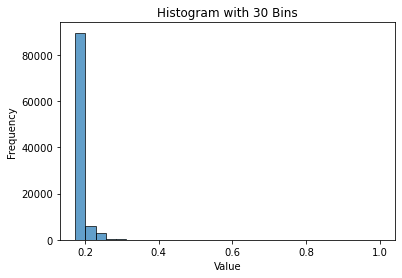

In [69]:
num_bins = 30  # Specify the number of bins
xx = flattened_tensor.mean(dim=1)
print(xx.shape)
plot_histogram(xx, num_bins)

In [70]:
duplicates_count = count_duplicates(flattened_tensor)
print(f"Number of duplicate rows: {duplicates_count}")

Number of duplicate rows: 0


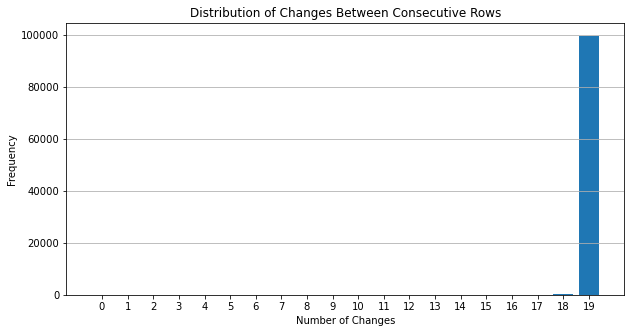

In [71]:
changes_distribution = calculate_changes_distribution(generated_tensor)
plot_changes_distribution(changes_distribution)

In [64]:
flattened_tensor[10]

tensor([1.0000e+00, 1.0000e-04, 9.9960e-01, 5.9986e-04, 9.9860e-01, 1.4990e-03,
        9.9703e-01, 2.7962e-03, 9.9490e-01, 4.4902e-03, 9.9220e-01, 6.5786e-03,
        9.8895e-01, 9.0592e-03, 9.8513e-01, 1.1929e-02, 9.8076e-01, 1.5184e-02,
        9.7585e-01, 1.8821e-02, 1.0000e-04, 1.0000e-08, 9.9961e-05, 5.9986e-08,
        9.9861e-05, 1.4990e-07, 9.9704e-05, 2.7963e-07, 9.9491e-05, 4.4902e-07,
        9.9221e-05, 6.5787e-07, 9.8896e-05, 9.0593e-07, 9.8514e-05, 1.1929e-06,
        9.8077e-05, 1.5184e-06, 9.7586e-05, 1.8822e-06, 9.9960e-01, 9.9961e-05,
        9.9920e-01, 5.9962e-04, 9.9820e-01, 1.4984e-03, 9.9664e-01, 2.7951e-03,
        9.9450e-01, 4.4884e-03, 9.9181e-01, 6.5760e-03, 9.8855e-01, 9.0556e-03,
        9.8474e-01, 1.1924e-02, 9.8037e-01, 1.5178e-02, 9.7546e-01, 1.8814e-02,
        5.9986e-04, 5.9986e-08, 5.9962e-04, 3.5983e-07, 5.9902e-04, 8.9916e-07,
        5.9808e-04, 1.6773e-06, 5.9680e-04, 2.6934e-06, 5.9518e-04, 3.9462e-06,
        5.9323e-04, 5.4342e-06, 5.9094e-

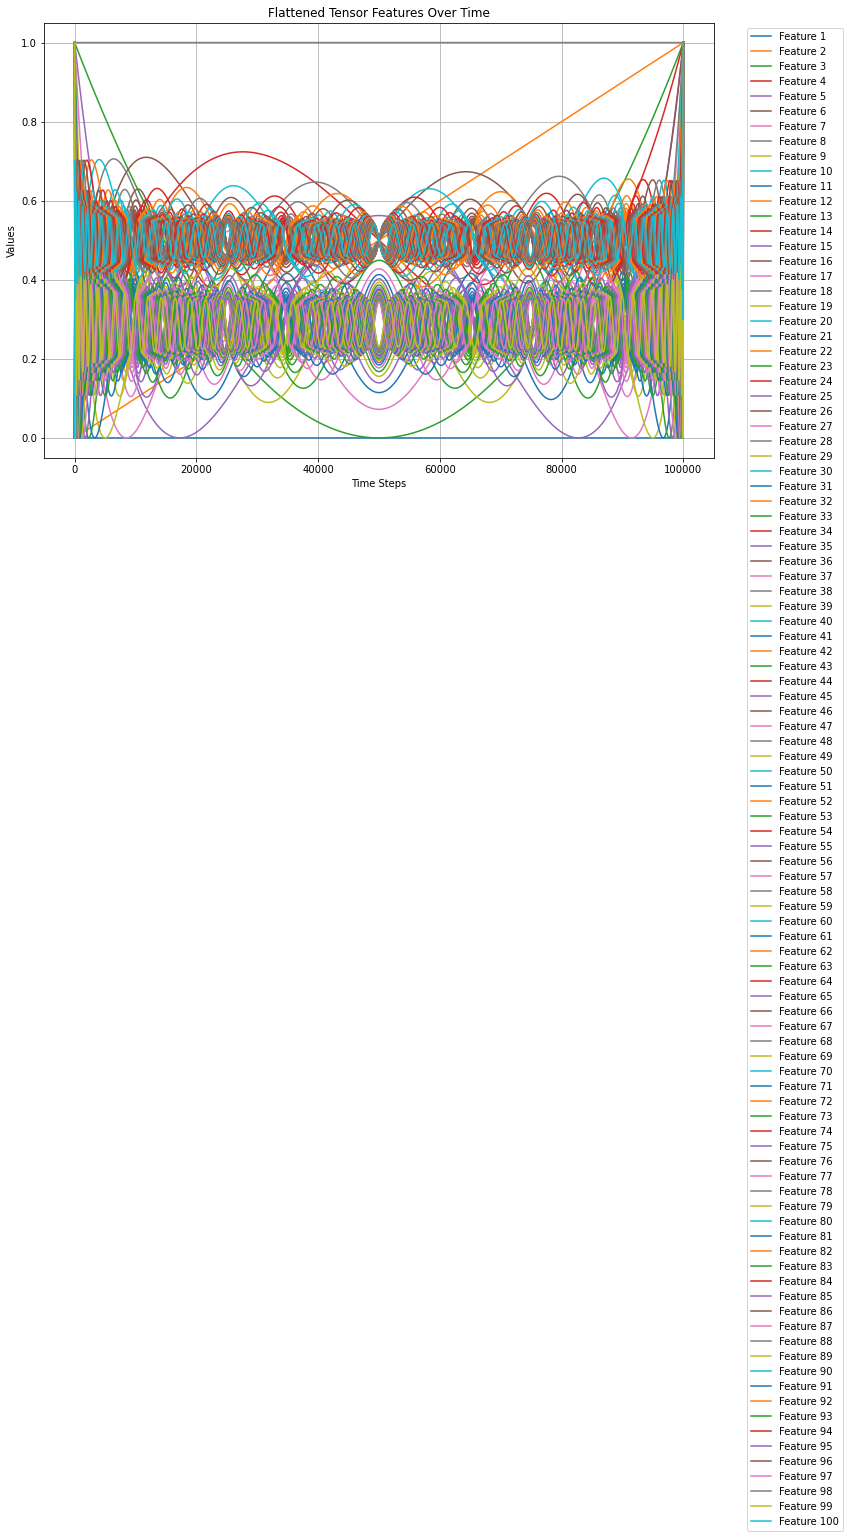

In [77]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Assuming flattened_tensor is already defined
# flattened_tensor = outer_product.reshape(outer_product.shape[0], -1)

# Create a time variable (assuming equal spacing)
time_steps = np.arange(generated_tensor.shape[0])

# Plot each feature in the flattened tensor
plt.figure(figsize=(12, 8))
for i in range(generated_tensor.shape[1]):
    plt.plot(time_steps, generated_tensor[:, i].numpy(), label=f'Feature {i+1}')

plt.title('Flattened Tensor Features Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Values')
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.grid()
plt.show()


In [89]:
generated_tensor[:,-1][:20]

tensor([0.0000, 0.1801, 0.3255, 0.4408, 0.5300, 0.5969, 0.6446, 0.6762, 0.6943,
        0.7012, 0.6989, 0.6893, 0.6740, 0.6544, 0.6317, 0.6069, 0.5810, 0.5547,
        0.5287, 0.5034])

In [8]:
def prime_numbers_up_to_n(n):
    primes = []
    for num in range(2, n + 1):
        is_prime = True
        for i in range(2, int(num**0.5) + 1):
            if num % i == 0:
                is_prime = False
                break
        if is_prime:
            primes.append(num)
    return primes


def create_oscillating_tensor(int_list, input_length):
    # Initialize the tensor with zeros
    tensor = torch.zeros((input_length, len(int_list)), dtype=torch.float32)

    for i, value in enumerate(int_list):
        # Create the oscillating pattern for the current integer
        pattern = [1] * value + [0] * value  # [1, 1, ..., 0, 0] of length 2*value
        # Repeat the pattern to fill the tensor
        repeated_pattern = (pattern * (input_length // (2 * value))) + pattern[:input_length % (2 * value)]
        # Assign to the corresponding column of the tensor
        tensor[:, i] = torch.tensor(repeated_pattern)

    return tensor




# Get prime numbers up to 1000
prime_numbers = prime_numbers_up_to_n(10000)
prime_numbers = [1] + prime_numbers


In [9]:
len(prime_numbers)

1230

In [10]:
prime_numbers

[1,
 2,
 3,
 5,
 7,
 11,
 13,
 17,
 19,
 23,
 29,
 31,
 37,
 41,
 43,
 47,
 53,
 59,
 61,
 67,
 71,
 73,
 79,
 83,
 89,
 97,
 101,
 103,
 107,
 109,
 113,
 127,
 131,
 137,
 139,
 149,
 151,
 157,
 163,
 167,
 173,
 179,
 181,
 191,
 193,
 197,
 199,
 211,
 223,
 227,
 229,
 233,
 239,
 241,
 251,
 257,
 263,
 269,
 271,
 277,
 281,
 283,
 293,
 307,
 311,
 313,
 317,
 331,
 337,
 347,
 349,
 353,
 359,
 367,
 373,
 379,
 383,
 389,
 397,
 401,
 409,
 419,
 421,
 431,
 433,
 439,
 443,
 449,
 457,
 461,
 463,
 467,
 479,
 487,
 491,
 499,
 503,
 509,
 521,
 523,
 541,
 547,
 557,
 563,
 569,
 571,
 577,
 587,
 593,
 599,
 601,
 607,
 613,
 617,
 619,
 631,
 641,
 643,
 647,
 653,
 659,
 661,
 673,
 677,
 683,
 691,
 701,
 709,
 719,
 727,
 733,
 739,
 743,
 751,
 757,
 761,
 769,
 773,
 787,
 797,
 809,
 811,
 821,
 823,
 827,
 829,
 839,
 853,
 857,
 859,
 863,
 877,
 881,
 883,
 887,
 907,
 911,
 919,
 929,
 937,
 941,
 947,
 953,
 967,
 971,
 977,
 983,
 991,
 997,
 1009,
 1013,
 10

In [115]:
# Example usage
int_list = prime_numbers
input_length = 100000
result_tensor = create_oscillating_tensor(int_list, input_length)
print(result_tensor)

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [0., 1., 1.,  ..., 1., 1., 1.],
        [1., 0., 1.,  ..., 1., 1., 1.],
        ...,
        [0., 1., 1.,  ..., 1., 1., 1.],
        [1., 0., 1.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.]])


In [116]:
duplicates_count = count_duplicates(result_tensor)
print(f"Number of duplicate rows: {duplicates_count}")

Number of duplicate rows: 4


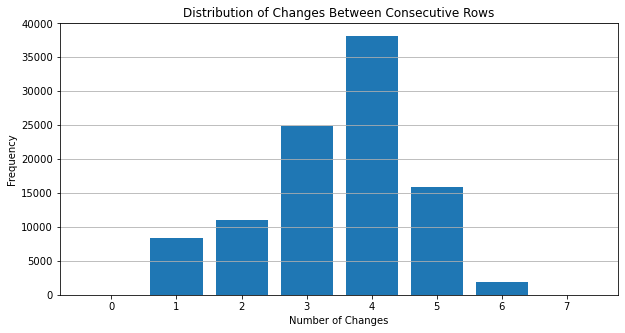

In [117]:
changes_distribution_s = calculate_changes_distribution(result_tensor)
plot_changes_distribution(changes_distribution_s)

In [61]:
int_list = [i+1 for i in range(30)]
input_length = 10000
osc_1 = create_oscillating_tensor(int_list, input_length)
print(osc_1.shape)
duplicates_count = count_duplicates(osc_1)
print(f"Number of duplicate rows: {duplicates_count}")

torch.Size([10000, 30])
Number of duplicate rows: 0


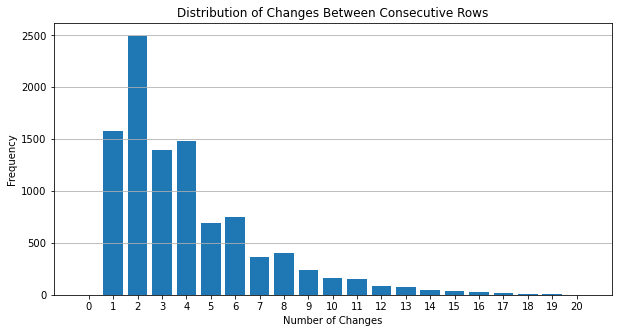

In [62]:
changes_distribution_s = calculate_changes_distribution(osc_1)
plot_changes_distribution(changes_distribution_s)

In [75]:
osc_1 = binary_sequence_tensor(20, input_length)

In [85]:
off_set = 41
test_in = osc_1[:-off_set]
test_out = osc_1[off_set:]
print(test_in.shape, test_out.shape)

torch.Size([9929, 20]) torch.Size([9929, 20])


In [86]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [95]:
# Assuming test_in and test_out are your input and output tensors
# Let's say you have batch size = N
batch_size = test_in.shape[0]





# Define a model with a variable number of layers
class MultiLayerModel(nn.Module):
    def __init__(self, input_dim, num_layers):
        super(MultiLayerModel, self).__init__()
        self.layers = nn.ModuleList()

        # Create the specified number of layers
        for _ in range(num_layers):
            self.layers.append(nn.Linear(input_dim, input_dim))  # Each layer has the same input and output dimension

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = layer(x)  # Pass through the layer
            if i < len(self.layers) - 1:  # Apply ReLU activation only for all but the last layer
                x = F.relu(x)
        return torch.sigmoid(x)   # Apply sigmoid activation at the end

# Example usage
input_dim = test_in.shape[1]
num_layers = 2  # Specify the number of layers

model = MultiLayerModel(input_dim, num_layers)

model

MultiLayerModel(
  (layers): ModuleList(
    (0-4): 5 x Linear(in_features=20, out_features=20, bias=True)
  )
)

In [116]:
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.002)  # You can adjust the learning rate


# Training loop
num_epochs = 1000  # Adjust as needed

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode

    optimizer.zero_grad()  # Clear gradients
    outputs = model(test_in)  # Forward pass
    
    loss = criterion(outputs, test_out)  # Calculate loss
    loss.backward()  # Backward pass
    optimizer.step()  # Update weights

    if (epoch + 1) % 10 == 0:  # Print every 10 epochs
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# After training, you can evaluate your model on validation data if needed

Epoch [10/1000], Loss: 0.1185
Epoch [20/1000], Loss: 0.0815
Epoch [30/1000], Loss: 0.0695
Epoch [40/1000], Loss: 0.0676
Epoch [50/1000], Loss: 0.0670
Epoch [60/1000], Loss: 0.0667
Epoch [70/1000], Loss: 0.0664
Epoch [80/1000], Loss: 0.0663
Epoch [90/1000], Loss: 0.0663
Epoch [100/1000], Loss: 0.0663
Epoch [110/1000], Loss: 0.0663
Epoch [120/1000], Loss: 0.0662
Epoch [130/1000], Loss: 0.0662
Epoch [140/1000], Loss: 0.0662
Epoch [150/1000], Loss: 0.0662
Epoch [160/1000], Loss: 0.0662
Epoch [170/1000], Loss: 0.0662
Epoch [180/1000], Loss: 0.0662
Epoch [190/1000], Loss: 0.0662
Epoch [200/1000], Loss: 0.0662
Epoch [210/1000], Loss: 0.0662
Epoch [220/1000], Loss: 0.0662
Epoch [230/1000], Loss: 0.0662
Epoch [240/1000], Loss: 0.0662
Epoch [250/1000], Loss: 0.0662
Epoch [260/1000], Loss: 0.0662
Epoch [270/1000], Loss: 0.0662
Epoch [280/1000], Loss: 0.0662
Epoch [290/1000], Loss: 0.0662
Epoch [300/1000], Loss: 0.0661
Epoch [310/1000], Loss: 0.0661
Epoch [320/1000], Loss: 0.0661
Epoch [330/1000],

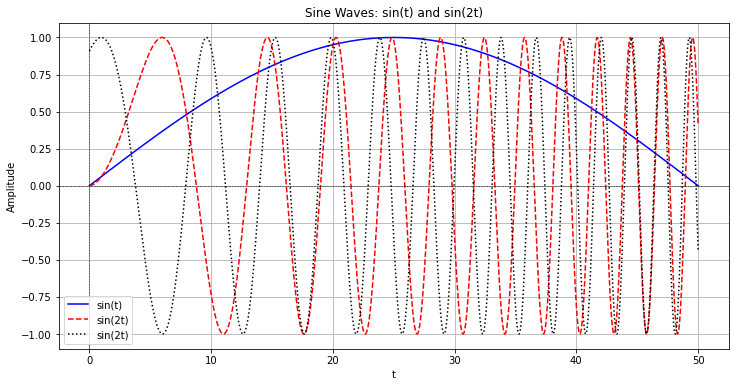

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
t = np.linspace(0, 50, 10000)  # Original time variable
frequency = 0.01  # Frequency of the sine wave
factor = 1.8  # Factor by which to increase t for the second sine wave

# Calculate sine waves
y1 = np.sin(2 * np.pi * frequency * t)  # Sine wave with original t
y2 = np.sin(2 * np.pi * frequency * ((t) ** factor))   # Sine wave with increased t
y3 = np.sin(2 * np.pi * frequency * ((t+5) ** (1*factor))) 

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(t, y1, label='sin(t)', color='blue')
plt.plot(t, y2, label='sin(2t)', color='red', linestyle='--')
plt.plot(t, y3, label='sin(2t)', color='black', linestyle=':')
plt.title('Sine Waves: sin(t) and sin(2t)')
plt.xlabel('t')
plt.ylabel('Amplitude')
plt.axhline(0, color='black',linewidth=0.5, ls='--')
plt.axvline(0, color='black',linewidth=0.5, ls='--')
plt.legend()
plt.grid()
plt.show()


In [ ]:
i think i want a low frequency part everywhere, so this isn't quite right.  mess

You can see that each position 
 corresponds to a different sinusoid, which encodes a single position into a vector. If you look closely at the positional encoding function, you can see that the wavelength for a fixed 
 is given by:


Hence, the wavelengths of the sinusoids form a geometric progression and vary from 
 to 
. The scheme for positional encoding has a number of advantages.
That is from that page i site in 

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Define the function to get position encoding
def getPositionEncoding(seq_len, d, n=10000):
    P = np.zeros((seq_len, d))
    for k in range(seq_len):
        for i in np.arange(int(d / 2)):
            denominator = np.power(n, 2 * i / d)
            P[k, 2 * i] = np.sin(k / denominator)
            P[k, 2 * i + 1] = np.cos(k / denominator)
    return P

# Get position encoding for the given parameters
P = getPositionEncoding(seq_len=1000, d=2)



In [20]:
pt = torch.tensor(P)

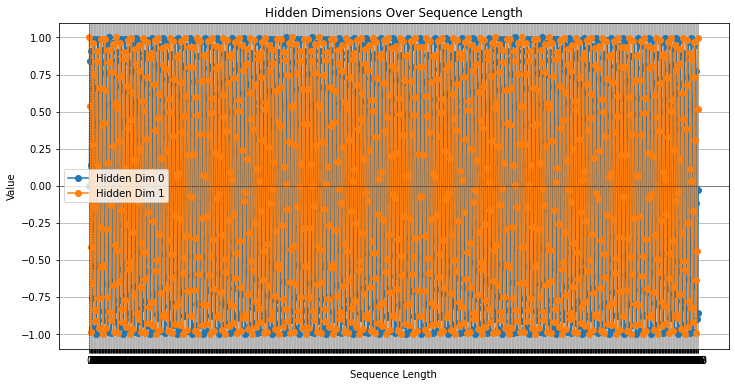

In [21]:
seq_len = pt.shape[0]
hidden_dim = pt.shape[-1]
tensor = pt  # Random values for demonstration

# Plotting the tensor as line graphs for each hidden dimension
plt.figure(figsize=(12, 6))
for dim in range(hidden_dim):
    plt.plot(np.arange(seq_len), tensor[:, dim], marker='o', label=f'Hidden Dim {dim}')

plt.title('Hidden Dimensions Over Sequence Length')
plt.xlabel('Sequence Length')
plt.ylabel('Value')
plt.xticks(np.arange(seq_len))
plt.axhline(0, color='black', linewidth=0.5, ls='--')
plt.axvline(0, color='black', linewidth=0.5, ls='--')
plt.legend()
plt.grid()
plt.show()

In [ ]:
so, use a positional encoding and a sequence encoding to mess with the time encoding.  then the sequence and contingent time encoding are used to make the prediciotn
